In [3]:
# 미래 버전과의 호환성을 위한 설정 (Python 2/3 코드 혼용 방지용)
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow 및 Keras 백엔드 모듈 불러오기
import tensorflow as tf
import tensorflow.keras.backend as K

# 기본적인 파이썬 표준 라이브러리
import os        # 파일 및 디렉토리 경로 처리
import re        # 정규 표현식 처리
import math      # 수학 함수들
import numpy as np      # 수치 계산 및 배열 처리
import pandas as pd     # 데이터프레임 처리
import random           # 무작위 수 생성
import collections      # Counter, defaultdict 등 데이터 구조
import json             # JSON 파일 읽기/쓰기
import shutil           # 파일 복사, 이동 등
import zipfile          # zip 압축 파일 처리
import copy             # 객체 깊은 복사
from datetime import datetime  # 현재 시각 기록

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

# SentencePiece: 서브워드 토크나이저 (BPE, Unigram 등)
import sentencepiece as spm

# tqdm: 진행률 표시 바 (노트북 환경용)
from tqdm.notebook import tqdm

# 무작위성 제어: 재현 가능한 실험을 위해 시드 고정
random_seed = 1234
random.seed(random_seed)           # 파이썬 random 모듈 시드 고정
np.random.seed(random_seed)        # 넘파이 시드 고정
tf.random.set_seed(random_seed)    # 텐서플로우 시드 고정

# TensorFlow 버전 확인
print(tf.__version__)

# 현재 사용 가능한 GPU 디바이스 목록 확인
print(tf.config.list_physical_devices('GPU'))

# 현재 연결된 GPU 이름 출력 (없을 경우 공백 출력)
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [4]:
# 데이터와 모델 경로 설정
# os.getenv('HOME')은 현재 사용자의 홈 디렉토리 경로를 불러옵니b다.
# 예: '/home/username' 또는 '/Users/username'
data_dir = os.getenv('HOME') + '/aiffel/bert_pretrain/data'     # 학습용 데이터가 저장될 경로
model_dir = os.getenv('HOME') + '/aiffel/bert_pretrain/models'  # 사전학습된 토크나이저 모델(.model, .vocab)이 저장된 경로

# SentencePiece 토크나이저 불러오기
vocab = spm.SentencePieceProcessor()  # SentencePieceProcessor 객체 생성
vocab.load(f"{model_dir}/ko_32000.model")  # 학습된 서브워드 모델(.model 파일)을 로드

True

# 1. Sentence Piece 코드를 이해하기 위한 코드

**목표**

1. 토큰과 인덱스를 자유자재로 변환할수 있는지
2. 특수 토큰들은 7개임을 확인해볼 수 있었음.
3. encode -> decode 흐름을 알아보기

In [5]:
#===================================================
# 토크나이저 Sentence Piece 사용법을 알아보기
#===================================================

# 1️⃣ 예시 단어 → ID 확인
print("1️⃣ 예시 단어 '_기' → ID 확인")
print("단어 '_기'의 ID:", vocab.piece_to_id("_기"))  # '_'는 공백을 의미 (▁기)

# 2️⃣ ID → 서브워드 확인
print("\n2️⃣ ID → 서브워드 매핑 확인 (ID 0~10)")
for i in range(11):
    print(f"ID {i}의 토큰:", vocab.id_to_piece(i))

# 3️⃣ 서브워드 → ID → 다시 서브워드
print("\n3️⃣ 서브워드 '_1'의 ID → 다시 토큰 확인")
piece = "_1"
piece_id = vocab.piece_to_id(piece)
print(f"'{piece}'의 ID:", piece_id)
print("ID → 토큰:", vocab.id_to_piece(piece_id))

# 4️⃣ UNK 여부 확인
print("\n4️⃣ ID 0이 UNK([UNK])인지 확인")
print("ID 0이 UNK인가?:", vocab.is_unknown(0))

# 5️⃣ 인코딩 & 디코딩 전체 흐름 확인
print("\n5️⃣ 전체 encode → decode 흐름")
text = "나는 오늘 기분이 좋다"
ids = vocab.encode(text)
tokens = vocab.encode(text, out_type=str)
reconstructed = vocab.decode(ids)

print("입력 문장:", text)
print("서브워드 (문자 토큰):", tokens)
print("ID 목록:", ids)
print("복원된 문장:", reconstructed)

1️⃣ 예시 단어 '_기' → ID 확인
단어 '_기'의 ID: 1

2️⃣ ID → 서브워드 매핑 확인 (ID 0~10)
ID 0의 토큰: [PAD]
ID 1의 토큰: [UNK]
ID 2의 토큰: [BOS]
ID 3의 토큰: [EOS]
ID 4의 토큰: [SEP]
ID 5의 토큰: [CLS]
ID 6의 토큰: [MASK]
ID 7의 토큰: ▁1
ID 8의 토큰: ▁이
ID 9의 토큰: 으로
ID 10의 토큰: 에서

3️⃣ 서브워드 '_1'의 ID → 다시 토큰 확인
'_1'의 ID: 1035
ID → 토큰: _1

4️⃣ ID 0이 UNK([UNK])인지 확인
ID 0이 UNK인가?: False

5️⃣ 전체 encode → decode 흐름
입력 문장: 나는 오늘 기분이 좋다
서브워드 (문자 토큰): ['▁나는', '▁오늘', '▁기', '분이', '▁좋다']
ID 목록: [4344, 1613, 24, 4054, 9328]
복원된 문장: 나는 오늘 기분이 좋다


# 2. Vocab_list를 만들어보기

## **왜 Vocab_list를 만들어야 하는걸까?**

BERT에서의 Pretrained 에서는 두가지 주요 학습 과제가 존재한다. 

문장 간 관계를 예측하는 **NSP(Next Sentence Prediction)** 

문장 내 일부 토큰을 가려놓고 원래의 단어를 예측하는 **MLM(Masked Language Modeling)** 이다.

이 중 MLM은 입력 문장에서 일부 토큰을 무작위로 선택하여 [MASK]로 가리고 모델이 그 위치에 어떤 단어가 들어갈지 예측한다.


이 과정을 구현할 때 중요한 점은, 무작위로 선택된 토큰이 모두 예측 가능한 '일반적인 단어'여야 한다는 것. 

만약 [MASK]로 가린 자리에 원래 들어있던 단어가 [PAD]나 [UNK] 같은 특수 토큰이라면, 

모델은 아무리 학습해도 유의미한 결과를 낼 수 없습니다. 

이런 특수 토큰은 문장의 구조나 입력 처리에는 필요하지만, 

실제 의미 예측의 대상이 될 수는 없기 때문입니다.

---

이러한 이유로, 일반적인 토큰만 모아둔 리스트가 필요하며, 

그것이 바로 vocab_list이다. 

vocab_list는 SentencePiece로부터 얻은 전체 토큰 집합에서 [PAD], [UNK], [CLS], [SEP], [MASK] 등과 같이 모델 구조나 문장 경계를 처리하기 위한 특수 토큰들을 제외한 나머지 토큰들만 추출하여 만든 리스트입니다.


In [6]:
vocab_list = []

for id in range(7, 8007): # 8007을 입력해 8000개의 vocab_size를 확보한다.
        if not vocab.is_unknown(id): # 특수 토큰이 아니라면
            token = vocab.id_to_piece(id) # 토큰 문자열로 변환하고
            vocab_list.append(token) # vocab_list에 append 한다.

print(vocab_list[:10])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']


In [7]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


# 3. 데이터 전처리 (1) MASK 생성

## 3.1 원활한 MLM을 위한 띄어쓰기 기준으로 마스킹하기 



In [8]:
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt# 마스크해야하는 단어의 수만 알 수 있는 것

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


10

Subword 기반으로 토크나이징 했을 때 띄어쓰기가 없다면 한 단어 내의 것들이 마킹될 수 있기 때문에 먼저 **띄어쓰기 단위로 마스킹**해주는 작업을 진행한다.

In [9]:
cand_idx = []  # word 단위의 토큰 인덱스를 담는 리스트. 예: [[1,2], [3], [4,5,6], ...]

for (i, token) in enumerate(tokens_org):  # 전체 토큰을 하나씩 순회하면서
    if token == "[CLS]" or token == "[SEP]":
        continue  # 특수 토큰은 마스킹 후보에서 제외

    # u"\u2581"는 '▁' 문자 → SentencePiece에서 단어의 시작을 의미
    # 현재 토큰이 '▁'로 시작하지 않으면 이전 단어의 연속 토큰으로 간주
    
    # 지금 candidate_idx 라는 리스트에 하나 이상의 단어리스트가 있는지, 그리고 _로 시작하지 않았을 경우에는
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"): 
        cand_idx[-1].append(i)  # 이전 단어에 이어 붙임 (예: '▁추적', '추', '적' → 같은 단어)
    else: # _로 시작했을 경우에는
        cand_idx.append([i])  # 새로운 단어의 시작 → 새 리스트 생성하여 추가

# 결과 확인: 단어 단위로 묶인 인덱스와 대응하는 토큰들 출력
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])


[1, 2, 3] ['▁추적', '추', '적']
[4] ['▁비가']
[5] ['▁내리는']
[6, 7, 8] ['▁날', '이었', '어']
[9, 10] ['▁그날', '은']
[11, 12, 13] ['▁', '왠', '지']
[14, 15] ['▁손', '님이']
[16] ['▁많아']
[17] ['▁첫']
[18] ['▁번에']
[19, 20] ['▁삼', '십']
[21] ['▁전']
[22, 23] ['▁둘째', '번']
[24, 25] ['▁오', '십']
[26] ['▁전']
[27, 28] ['▁오랜', '만에']
[29, 30] ['▁받아', '보는']
[31] ['▁십']
[32, 33] ['▁전', '짜리']
[34, 35, 36] ['▁백', '통', '화']
[37, 38, 39] ['▁서', '푼', '에']
[41] ['▁손바닥']
[42, 43] ['▁위', '엔']
[44, 45] ['▁기쁨', '의']
[46, 47] ['▁눈', '물이']
[48] ['▁흘러']
[49, 50, 51] ['▁컬', '컬', '한']
[52] ['▁목에']
[53, 54] ['▁모', '주']
[55, 56, 57] ['▁한', '잔', '을']
[58, 59] ['▁적', '셔']
[60] ['▁몇']
[61] ['▁달']
[62] ['▁포']
[63] ['▁전부터']
[64, 65, 66] ['▁콜', '록', '거리는']
[67] ['▁아내']
[68] ['▁생각에']
[69, 70] ['▁그', '토록']
[71] ['▁먹고']
[72, 73] ['▁싶다', '던']


## 3.2 Random_mask 적용하기

### ❓ 왜 index shuffle 을 해야하냐?

vocab_index : 랜덤한 다른 단어로 바꿀 때 선택 대상이 되는 토큰 리스트

idex_shuffle을 하는 대상은 **cand_idx**임

cand_idx는, 한 문장 내의 마스킹 후보 단어 인덱스를 섞는 작업이다.

목적은 문장 내 다양한 위치의 단어들을 무작위로 선택하기 위해서이다.

자세한건 콬드를 통해 한번 보자


### ❓ 왜 Random_mask 를 적용해야하냐?

Random_mask는 단순히 [MASK]로만 가리는 것이 아니라

마스킹 대상 토큰 중 일부를 랜덤 토큰 또는 그대로 유지하는 거라서 확률에 따라 결정된다.

확률에서 특이한건 일정 비율을 주는게 아니라, dice라는 진짜 주사위를 굴려버린다.



In [10]:
# random mask를 위해서 index 순서를 섞음
# 순서를 섞는 이유는 dice는 마스킹 방식을 정하는 랜덤임. 
random.shuffle(cand_idx)

print("1️⃣ 셔플이 돌아간 cand_idx : 이 중에서 앞에서 15% 만큼 마스킹하기 때문에 셔플해줘야한다. ")

cand_idx

1️⃣ 셔플이 돌아간 cand_idx : 이 중에서 앞에서 15% 만큼 마스킹하기 때문에 셔플해줘야한다. 


[[18],
 [44, 45],
 [24, 25],
 [49, 50, 51],
 [31],
 [63],
 [41],
 [52],
 [22, 23],
 [71],
 [17],
 [19, 20],
 [60],
 [32, 33],
 [62],
 [46, 47],
 [29, 30],
 [72, 73],
 [6, 7, 8],
 [64, 65, 66],
 [67],
 [9, 10],
 [26],
 [55, 56, 57],
 [61],
 [34, 35, 36],
 [37, 38, 39],
 [21],
 [58, 59],
 [48],
 [69, 70],
 [4],
 [27, 28],
 [42, 43],
 [14, 15],
 [68],
 [5],
 [11, 12, 13],
 [1, 2, 3],
 [16],
 [53, 54]]

In [11]:
# tokens가 마스킹되므로, 원본 tokens_org를 복사해서 사용 (테스트 반복용)
tokens = copy.deepcopy(tokens_org)

# mask_lms: 마스킹된 토큰들의 인덱스와 정답(label) 저장용 리스트
mask_lms = []

# cand_idx: 단어 단위로 묶인 토큰 인덱스 리스트
for index_set in cand_idx:
    # 현재까지 마스킹한 토큰 수가 mask_cnt(15%) 이상이면 중단
    if len(mask_lms) >= mask_cnt:
        break

    # 이번에 마스킹하려는 단어(index_set 전체)를 추가했을 때 15%를 초과하면 skip <- 한 단어에서 추론하는 걸 방지하기 위함. 이거 없애도 되지 않나?
    if len(mask_lms) + len(index_set) > mask_cnt:
        continue

    # 0.0 ~ 1.0 사이의 랜덤 확률 생성 → 어떤 방식으로 마스킹할지 결정하는 데 사용
    dice = random.random()

    # 단어(= index_set)를 구성하는 각 토큰에 대해 마스킹 적용
    for index in index_set:
        masked_token = None

        if dice < 0.8:
            # 80% 확률로 [MASK] 토큰으로 대체
            masked_token = "[MASK]"
        elif dice < 0.9:
            # 10% 확률로 원래 토큰 유지 (identity)
            masked_token = tokens[index]
        else:
            # 10% 확률로 다른 랜덤 토큰으로 대체 (vocab_list에서 선택)
            masked_token = random.choice(vocab_list)

        # 마스킹된 토큰 정보 저장: 원래 위치와 정답 레이블
        mask_lms.append({"index": index, "label": tokens[index]})

        # 실제 마스킹 적용
        tokens[index] = masked_token

# 결과 출력
print("tokens_org")  # 원본 (마스킹 전) 토큰
print(tokens_org, "\n")

print("tokens")  # 마스킹된 토큰
print(tokens)

tokens_org
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '[MASK]', '▁삼', '십', '▁전', '▁둘째', '번', '[MASK]', '[MASK]', '▁전', '▁오랜', '만에', '▁받아', '보는', 'ud', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘러', '[MASK]', '[MASK]', '[MASK]', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


### 토큰을 보게 되면 알 수 있는 것

1. shuffle 을 했을 때 위에 있는 것 부터 하나씩 마스킹되어간다는 것을 알 수 있음. 
2. [34, 35, 36],[52],[44, 45],[9, 10],[55, 56, 57] 딱 이만큼 이제 마스킹된거임.
3. 그래서 Shuffle 후 랜덤 다이스 돌려서 마스킹하는 거임!

여기까지는 완벽 이해 완료 

## 3.3 학습용 데이터로 정리하기

마스킹이 적용된 토큰들에 대해, 어디 위치가 마스킹되었고, 정답을 알려주는 과정이다.

1. 마스킹 리스트 정렬을 한다. (Merge Sort)
2. 마스킹 인덱스만 추출한다.
3. 마스킹된 정답 토큰을 추출한다. (원래 있었던 정답 토큰만 추출한다.) 
4. 최종적으로 학습에 쓰일 마스킹 위치와 정답 토큰을 출력하여 디버깅하거나 검토한다.


In [12]:
# 마스킹된 토큰 정보를 index 기준으로 정렬
# 예: [{"index": 8, "label": "다"}, {"index": 2, "label": "▁기"}] → [{"index": 2, "label": "▁기"}, {"index": 8, "label": "다"}]
mask_lms = sorted(mask_lms, key=lambda x: x["index"])

# 마스킹된 위치만 추출하여 리스트로 저장 (모델이 예측할 위치 정보)
mask_idx = [p["index"] for p in mask_lms]

# 마스킹된 위치에 원래 있었던 정답 토큰만 추출하여 리스트로 저장 (모델이 예측해야 할 정답)
mask_label = [p["label"] for p in mask_lms]

# 결과 확인
print("mask_idx   :", mask_idx)    # 예: [2, 8]
print("mask_label :", mask_label)  # 예: ['▁기', '다']

mask_idx   : [18, 24, 25, 31, 44, 45, 49, 50, 51, 63]
mask_label : ['▁번에', '▁오', '십', '▁십', '▁기쁨', '의', '▁컬', '컬', '한', '▁전부터']


## 3.4 모듈화 진행하기 
group_tokens_by_word(): 서브워드 토큰을 단어 단위 인덱스로 묶기

shuffle_candidates(): 마스킹 후보 인덱스 셔플

apply_random_mask() : MLM 방식에 따라 실제 마스킹 적용

extract_mask_targets() : 정답 레이블 및 인덱스 정리

create_masked_tokens(): 전체 마스킹 파이프라인 통합 실행


In [13]:
def group_tokens_by_word(tokens_org):
    cand_idx = []  # word 단위의 토큰 인덱스를 담는 리스트. 예: [[1,2], [3], [4,5,6], ...]
    for (i, token) in enumerate(tokens_org):  # 전체 토큰을 하나씩 순회하면서
        if token == "[CLS]" or token == "[SEP]":
            continue  # 특수 토큰은 마스킹 후보에서 제외
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)  # 이전 단어에 이어 붙임 (예: '▁추적', '추', '적' → 같은 단어)
        else:
            cand_idx.append([i])  # 새로운 단어의 시작 → 새 리스트 생성하여 추가

#     # 결과 확인: 단어 단위로 묶인 인덱스와 대응하는 토큰들 출력
#     for cand in cand_idx:
#         print(cand, [tokens_org[i] for i in cand])
    return cand_idx

In [14]:
def shuffle_candidates(cand_idx):
    random.shuffle(cand_idx)
    return cand_idx

In [15]:
def apply_random_mask(tokens_org, cand_idx, mask_cnt, voacb_list):
    
    tokens = copy.deepcopy(tokens_org)                 # 복사용
    mask_lms = []

    for index_set in cand_idx:                        # 셔플된거에서 순회 시작
        if len(mask_lms) >= mask_cnt:                 # 정지 조건
            break
        if len(mask_lms) + len(index_set) > mask_cnt: # 스킵 조건
            continue

        dice = random.random()                        # 다이스 굴리고
    
        for index in index_set:                       # MLM 규칙
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)

            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    return tokens, mask_lms                          # 토큰이랑, mask_lms에 딕셔너리를 가지고 있음.

In [16]:
def extract_mask_targets(mask_lms):
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
    return mask_idx, mask_label

In [17]:
def create_masked_tokens(tokens_org, mask_cnt, vocab_list):
    cand_idx = group_tokens_by_word(tokens_org)
    cand_idx = shuffle_candidates(cand_idx)
    tokens, mask_lms = apply_random_mask(tokens_org, cand_idx, mask_cnt, vocab_list)
    mask_idx, mask_label = extract_mask_targets(mask_lms)

    return tokens, mask_idx, mask_label

In [18]:
tokens, mask_idx, mask_label = create_masked_tokens(tokens_org, mask_cnt, vocab_list)

print("원본:", tokens_org)
print("")
print("================================================================================================")
print("")
print("마스킹된:", tokens)
print("")
print("================================================================================================")
print("")
print("mask_idx:", mask_idx)
print("")
print("================================================================================================")
print("")
print("mask_label:", mask_label)

원본: ['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


마스킹된: ['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '[MASK]', '[MASK]', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '[MASK]', '▁컬', '컬', '한', '[MASK]', '▁않기', '▁담고', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '[MASK]', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


mask_idx: [16, 17, 37, 38, 39, 48, 

# 4. 데이터 전처리(2) NSP pair 생성



**NSP pair란?**  BERT 사전학습 시 사용되는 **문장 A와 문장 B의 쌍**으로,  
문장 B가 실제로 문장 A 다음에 오는 문장인지 (`IsNext`)  
아니면 무작위로 끌어온 문장인지 (`NotNext`)를 모델이 예측하도록 구성된 데이터입니다.

In [19]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [20]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
# encode_as_pieces(line) 을 통해서 분리를 진행한다.
doc[:3]


[['▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어'],
 ['▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아'],
 ['▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '▁번', '▁오', '십', '▁전']]

In [21]:
# 전체 입력 시퀀스의 최대 길이 (예: BERT 모델이 처리할 수 있는 최대 길이)
n_test_seq = 64

# 너무 짧은 문장은 학습 효율이 낮기 때문에 최소 길이 설정
min_seq = 8

# 실제 입력 문장(tokens_a + tokens_b)의 최대 길이
# BERT는 [CLS], [SEP], [SEP] 총 3개의 특수 토큰을 사용하므로 그만큼 빼줌
max_seq = n_test_seq - 3

In [22]:
current_chunk = []   # 한 문단(doc) 안에서 라인(문장) 단위로 토큰을 모을 리스트
current_length = 0   # current_chunk에 있는 모든 토큰의 총 길이

for i in range(len(doc)):  # 문단(doc)의 각 문장을 하나씩 순회
    current_chunk.append(doc[i])           # 해당 줄의 토큰을 current_chunk에 추가
    current_length += len(doc[i])          # 해당 줄의 토큰 수를 current_length에 누적

    # 조건: 문장이 2줄 이상 쌓였고, 
    # (1) 현재 줄이 문단의 마지막이거나, 
    # (2) 누적된 토큰 수가 최대 허용 길이(max_seq)를 넘으면
    # 학습 데이터 생성을 위해 쪼개기 시작
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        ##########################################
        # ⬇ NSP를 위한 token A/B 분할 과정 시작

        # token_a: 앞부분 문장들 (1개 이상)
        a_end = 1  # 최소 한 문장은 A에 포함
        if 1 < len(current_chunk):  # 총 문장이 2줄 이상이면
            # 랜덤한 지점에서 문장을 자름 (0 ~ a_end-1 → A, 나머지 → B)
            a_end = random.randrange(1, len(current_chunk))

        tokens_a = []  # token A 초기화
        for j in range(a_end):  # 0부터 a_end 직전까지
            tokens_a.extend(current_chunk[j])  # 각 문장의 토큰들을 token_a에 붙이기

        # token_b: 나머지 뒷부분 문장들
        tokens_b = []
        for j in range(a_end, len(current_chunk)):  # a_end부터 끝까지
            tokens_b.extend(current_chunk[j])  # 토큰들을 token_b에 이어붙임

        # 결과 출력
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        ##########################################

        print()  # 구분을 위한 빈 줄 출력

        # 다음 NSP 샘플 생성을 위해 초기화
        current_chunk = []
        current_length = 0

current_chunk: 7 66 [['▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어'], ['▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아'], ['▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '▁번', '▁오', '십', '▁전'], ['▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러'], ['▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내']]
tokens_a: 16 ['▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아']
tokens_b: 50 ['▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '▁번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내']

current_chunk: 7 65 [['▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던'], ['▁설', '렁', '탕', '▁한', '▁그릇', '을', '▁이제는', '▁살', '▁수', '▁있어'], ['▁집으로', '▁돌아가는', '▁길', '

**trim_tokens(tokens_a, tokens_b, max_seq)**

전체 길이가 max_seq를 넘으면 긴 쪽에서 토큰을 삭제합니다.

삭제 방식:

1. tokens_a가 더 길면 앞에서 삭제 (del tokens_a[0])

2. tokens_b가 더 길면 뒤에서 삭제 (tokens_b.pop())

In [25]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

**create_nsp_pairs_from_doc(doc, max_seq):**

1. 여러 문장을 모아서 current_chunk에 누적합니다.

2. 문장 누적 길이가 max_seq를 넘거나 문단 끝에 도달하면 다음 단계로 넘어갑니다.

3. 누적된 문장들을 랜덤 지점에서 tokens_a와 tokens_b로 나눕니다.

4. 50% 확률로 tokens_a와 tokens_b를 바꿔치기 → 이때 is_next = 0 (False)

5. 총 길이가 max_seq보다 길면 잘라냄 → trim_tokens 호출

6. 둘 다 비어있지 않은 경우 NSP 데이터로 저장

In [26]:
def create_nsp_pairs_from_doc(doc, max_seq):
    """
    하나의 문단(doc)을 받아 NSP 학습용 문장쌍 생성
    :param doc: 문단 (토큰화된 문장 리스트들의 리스트)
    :param max_seq: 최대 길이 ([CLS], [SEP], [SEP] 제외한 길이)
    :return: NSP 쌍 리스트 [(tokens_a, tokens_b, is_next), ...]
    """
    nsp_data = []

    current_chunk = []   # 현재 모으고 있는 문장들
    current_length = 0   # 모인 토큰 길이 누적

    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])

        if len(current_chunk) > 1 and (i == len(doc) - 1 or current_length >= max_seq):
            # 랜덤 지점에서 문장 나누기
            a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # 50% 확률로 NotNext 만들기
            if random.random() < 0.5:
                is_next = 0  # False
                tokens_a, tokens_b = tokens_b, tokens_a  # 순서 뒤집기
            else:
                is_next = 1  # True

            # 최대 길이 초과 시 잘라내기
            trim_tokens(tokens_a, tokens_b, max_seq)

            # 최소 길이 보장
            if len(tokens_a) > 0 and len(tokens_b) > 0:
                nsp_data.append((tokens_a, tokens_b, is_next))

            # 초기화
            current_chunk = []
            current_length = 0

    return nsp_data

In [29]:
import random
import copy

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    하나의 문단(doc)을 받아 BERT pretrain용 인스턴스 생성 (NSP + MLM)
    :param vocab: {token: id} 형태의 vocab 딕셔너리
    :param doc: 문장 단위 토큰 리스트 예: [['나는', '학생이다'], ['오늘은', '날씨가', '좋다']]
    :param n_seq: 전체 시퀀스 최대 길이 (ex: 128)
    :param mask_prob: 마스킹 확률 (ex: 0.15)
    :param vocab_list: 마스킹 대상이 될 수 있는 일반 단어 리스트
    :return: instance 리스트 (dict 형태)
    """
    max_seq = n_seq - 3  # [CLS], [SEP], [SEP] 제외한 순수 토큰 최대 길이
    instances = []

    current_chunk = []
    current_length = 0

    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])

        if len(current_chunk) > 1 and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # 50% 확률로 NSP False
            if random.random() < 0.5:
                is_next = 0
                tokens_a, tokens_b = tokens_b, tokens_a
            else:
                is_next = 1

            # 길이 초과 시 자르기
            trim_tokens(tokens_a, tokens_b, max_seq)
            if len(tokens_a) == 0 or len(tokens_b) == 0:
                continue

            # tokens, segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            # 마스킹 (deepcopy로 원본 보존)
            tokens_masked, mask_idx, mask_label = create_masked_tokens(copy.deepcopy(tokens), int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens_masked,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0

    return instances


In [31]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁둘째', '조차', '▁오', '십', '▁꺼', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '[MASK]', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '[MASK]', '[MASK]', '▁콜', '록', '거리는', '▁아내', '[SEP]', '▁추적', '추', '적', '[MASK]', '[MASK]', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁노벨', '헝가', '▁많아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [2, 5, 26, 40, 41, 50, 51, 60, 61], 'mask_label': ['▁번', '▁전', '▁흘러', '▁포', '▁전부터', '▁비가', '▁내리는', '▁손', '님이']}
{'tokens': ['[CLS]', '▁생각에', '▁사용', '▁이로써', '▁먹고', '▁싶다', '던', '▁설', '렁', '탕', '▁한', '▁그릇', '을', '▁이제는', '▁살', '[MASK]', '▁있어', '▁집으로', '▁돌아가는', '▁길', '▁난', '▁문', '득', '▁떠올', '라', '[SEP]', '▁아내의', '▁목소리가', '▁이들은', '계는', '(15', '▁가는', '▁희',

# 5. 데이터 전처리(3) 데이터셋 완성

In [32]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

**이 다음 코드가 존재하는 이유**

각 문단의 문장 수와 대표 문장을 확인하여,

실제로 NSP 학습이 가능한 문단인지

너무 짧거나 문장이 없는 문단이 많은지

주제별로 분리된 자연스러운 문단인지 확인하기 위해 샘플 출력

In [37]:
import json

def pretty_print_instance(instance, max_len=30):
    print("▶ is_next:", instance['is_next'])
    
    # tokens 예쁘게 출력
    tokens_preview = instance['tokens'][:max_len]
    if len(instance['tokens']) > max_len:
        tokens_preview.append('...')
    print("▶ tokens:", tokens_preview)
    
    # segment 예쁘게 출력
    segment_preview = instance['segment'][:max_len]
    if len(instance['segment']) > max_len:
        segment_preview.append('...')
    print("▶ segment:", segment_preview)

    # 마스킹 정보
    print("▶ mask_idx:", instance['mask_idx'])
    print("▶ mask_label:", instance['mask_label'])
    print()

In [38]:
# 문단 샘플 5개만 출력해보기
count = 5  # 5개 문단만 출력

with open(corpus_file, 'r') as in_f:
    doc = []  # 한 문단 단위로 저장될 리스트
    for line in tqdm(in_f, total=total):  # tqdm으로 진행률 표시
        line = line.strip()  # 줄 끝 개행 문자 제거
        if line == "":  # 빈 줄 = 문단 구분자
            if 0 < len(doc):  # 누적된 문장이 있을 때만 처리
                if 0 < count:
                    count -= 1
                    # 문단 정보 출력 (몇 줄? 첫 줄, 중간 줄, 마지막 줄)
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break  # 5개 문단만 확인하고 종료
                doc = []  # 다음 문단을 위한 초기화
        else:
            # 빈 줄이 아닌 경우: 토크나이저로 토큰화 후 저장
            pieces = vocab.encode_as_pieces(line)  # 문장을 subword로 쪼갬
            if 0 < len(pieces):  # 토큰이 비어있지 않으면
                doc.append(pieces)

    # 파일 끝나고 마지막 문단이 남아 있는 경우
    if 0 < len(doc):
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []


  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지미', '▁카터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인권', '과', '▁중재', '▁역할에', '▁대한', '▁공로를', '▁인정받아', '▁노벨', '▁평화', '상을', '▁받게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념을', '▁다루는', '▁학문이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용해서', '▁공', '리로', '▁구성된', '▁추상', '적', '▁구조를', '▁연구하는', '▁학문', '으로', '▁여겨', '지기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학문', '들과', '▁깊은', '▁연', '관을', '▁맺고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학의', '▁분야', '들과는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지', '▁않는', '▁개념', '들에', '▁대해서', '까지', '▁이론을', '▁일반화', '▁및', '▁추상', '화', '시킬', '▁수', '▁있다는', '▁차이가', '▁있다고', '▁한다', '.', '▁수

In [44]:
count = 5  # 테스트용 문단 개수 제한

with open(corpus_file, 'r') as in_f:
    doc = []
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":
            if 0 < len(doc):
                # NSP+MLM instance 생성
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                print("doc:", len(doc), "instances:", len(instances))
                if len(instances) > 0:
                    pretty_print_instance(instances[0])
                doc = []
                count -= 1
                if 0 < count:
                    continue
                else:
                    break
        else:
            # 여기가 빠졌던 부분입니다!
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)

    # 마지막 문단 처리
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 9
▶ is_next: 1
▶ tokens: ['[CLS]', '[MASK]', '▁카터', '[SEP]', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '[MASK]', '[MASK]', '▁10', '월', '[MASK]', '[MASK]', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '[MASK]', '▁(19', '77', '...']
▶ segment: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '...']
▶ mask_idx: [1, 13, 14, 17, 18, 27, 42, 43, 57]
▶ mask_label: ['▁지미', '▁1924', '년', '▁1', '일', '▁대통령', '▁섬', '터', '▁후']

doc: 14 instances: 7
▶ is_next: 0
▶ tokens: ['[CLS]', '.', '▁하지만', ',', '[MASK]', '▁과학의', '[MASK]', '[MASK]', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지', '▁않는', '▁개념', '들에', '▁대해서', '까지', '▁이론을', '▁일반화', '▁및', '▁추상', '화', '시킬', '▁수', '▁표시', '▁차이가', '▁있다고', '▁한다', '...']
▶ segment: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '...']
▶ mask_idx: [4, 6, 7, 26, 36, 39, 40, 47, 48]
▶ mask_label: ['▁어느', '▁분야', '들과는', '▁있다는', '▁대해서', '▁하고', ',', '▁공리', '로부터의']

In [97]:
import json
from tqdm import tqdm

def make_pretrain_data(vocab, vocab_list, in_file, out_file, n_seq, mask_prob=0.15):
    """
    BERT pretraining 학습용 데이터를 생성하여 파일로 저장
    - vocab: SubwordTokenizer 객체
    - vocab_list: 마스킹 가능한 일반 토큰 리스트
    - in_file: 입력 파일 경로 (.txt)
    - out_file: 출력 파일 경로 (.jsonl)
    - n_seq: 최대 시퀀스 길이
    - mask_prob: MLM 마스킹 확률
    """

    def save_pretrain_instances(out_f, doc):
        # 문단(doc)으로부터 학습용 인스턴스들을 생성하고 저장
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    # 전체 라인 수 계산 (진행률 표시용)
    total_lines = 0
    with open(in_file, 'r') as f:
        for _ in f:
            total_lines += 1

    with open(in_file, 'r') as in_f:
        with open(out_file, 'w') as out_f:
            doc = []
            for line in tqdm(in_f, total=total_lines):
                line = line.strip()

                if line == "":
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if len(pieces) > 0:
                        doc.append(pieces)

            # 마지막 문단 처리
            if len(doc) > 0:
                save_pretrain_instances(out_f, doc)


In [98]:
pretrain_json_path = os.getenv('HOME') + '/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, vocab_list, corpus_file, pretrain_json_path, 128)

100%|██████████| 3957761/3957761 [06:36<00:00, 9994.12it/s] 


# 6. 메모리 사용량 최소화하는 방법(memmap)

### np.memmap이란?

`np.memmap`은 NumPy의 특수한 배열 객체로, **전체 데이터를 메모리에 모두 올리지 않고**  
**디스크 파일에 저장된 데이터를 필요한 부분만 메모리에 불러와서 사용하는 방식**입니다.

---

### 핵심 동작 원리

- 일반적인 `np.array`는 모든 데이터를 RAM에 올려야 하므로,
  대용량일 경우 **메모리 부족** 문제가 발생합니다.

- 반면 `np.memmap`은 파일의 일부분만 **슬라이스 단위로 로딩**하기 때문에,
  **RAM에 필요한 조각만 올라오고**, 나머지는 **디스크에 유지**됩니다.


### 사용 예시

```python
arr = np.memmap('data.memmap', dtype=np.float32, mode='w+', shape=(1000000,))
arr[0] = 42.0  # 이 때 0번 인덱스만 메모리에 올라옴


In [99]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [100]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]/tmp/ipykernel_62/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_62/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

data load early stop 128000 128000


In [101]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([    5,  2386,  2163,     6,     6,     6,  8047,   173,   607,
          2387,   317, 27604,  3926, 27625,  5551,    37, 18995,  8198,
          9858,  1447,     6,     6,  5551,    37,    18,   451,     6,
             6,  4864,  6436,    25,  5551, 27646, 18205,   928,   157,
         27821,    61, 27773,   530, 27604,  3372,   523,  3409,   673,
          5551,    18,   982, 13264, 27599,  5551,  5053,   982,  4739,
           151, 27604,  6945,  3554,  6719, 12788,  2046,  5890,  1853,
         27599,     4, 16415, 25250,  3324,  1042,   103, 27610, 27686,
         27718, 25250,  7504,   416,  5708, 27625,   131, 27662,     7,
         27629,   203,   241, 27602,  4867,   788,   243,  5898,   796,
           663,  1647,  4630, 27625,   203,  3008, 27625, 27616,    16,
         27599, 16415,   207,  4612,  5551, 27646,   630, 27714,  4269,
             6,     6,     6, 14406,  1605, 27599,  3050, 14146, 15991,
          8637, 27599,    13,    81,   729,  2247, 15033, 27873,

# 7. BERT 모델 구현하기

## 7.1 `get_pad_mask`

입력 시퀀스 중에서 PAD(=0) 위치를 찾아서 마스킹합니다.

마스킹된 위치는 attention 점수 계산 시 무시됩니다.

시퀀스 길이가 5지만, 실제 내용은 3개

```python

tokens = [[7, 21, 30, 0, 0]]   # 시퀀스 길이가 5지만, 실제 내용은 3개
get_pad_mask(tokens)
→ [[[[0, 0, 0, 1, 1]]]]       # 0 위치가 PAD로 마스킹됨  

```

✔ 함수의 목적

이 마스크를 적용하면 모델은 **"실제 단어들끼리만"** 의미 있는 관계를 학습할 수 있습니다.

만약 패딩까지 attention을 하게 되면, 의미 없는 정보에까지 weight(가중치)를 분산하게 되어 모델의 학습이 불안정하거나 부정확해질 수 있어요.

In [102]:
def get_pad_mask(tokens, i_pad=0):
    """
    패딩 마스크 생성 함수
    - 입력 시퀀스에서 PAD 토큰 위치를 1로 표시
    - 나머지 위치는 0으로 유지

    Args:
        tokens: 입력 토큰 시퀀스 (batch_size, n_seq)
        i_pad: PAD 토큰의 ID (기본값 0)

    Returns:
        mask: 패딩 마스크 (batch_size, 1, n_seq)
              → True(PAD 위치): 1.0, 나머지: 0.0
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)  # PAD인 위치만 1
    mask = tf.expand_dims(mask, axis=1)  # shape: (batch_size, 1, n_seq)
    return mask

## 7.2 `get_ahead_mask`

입력 시퀀스에서  
- **자기보다 뒤에 있는 토큰(미래)**  
- 그리고 **PAD 위치**를 함께 마스킹합니다.

이 마스크는 **디코더(Decoder)** 또는 **MLM(Masked Language Modeling)** 과제에서 주로 사용됩니다.  
즉, 모델이 미래 단어를 미리 보지 못하게 하고, 패딩 또한 무시하게 만듭니다.

---

### ✅ 예시 코드

```python
tokens = [[10, 25, 0]]   # 시퀀스 길이 3, 실제 단어는 2개
get_ahead_mask(tokens)

→ [[[0, 1, 1],
     [0, 0, 1],
     [0, 0, 1]]]


In [103]:
def get_ahead_mask(tokens, i_pad=0):
    """
    미래 정보 + PAD 마스킹 생성 함수
    - 자기보다 뒤에 있는 토큰과 PAD 위치를 모두 마스킹
    - 주로 Decoder나 Masked LM 등에서 사용

    Args:
        tokens: 입력 토큰 시퀀스 (batch_size, n_seq)
        i_pad: PAD 토큰의 ID (기본값 0)

    Returns:
        mask: 어헤드 마스크 (batch_size, n_seq, n_seq)
              → 미래 위치나 PAD 위치: 1.0, 나머지: 0.0
    """
    n_seq = tf.shape(tokens)[1]

    # 상삼각 행렬: 자기보다 미래 위치는 1, 나머지는 0
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)  # shape: (n_seq, n_seq)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)  # (1, n_seq, n_seq)

    # 패딩 마스크: (batch_size, 1, n_seq)
    pad_mask = get_pad_mask(tokens, i_pad)

    # 둘 중 하나라도 1이면 마스킹: 미래 또는 PAD 위치
    mask = tf.maximum(ahead_mask, pad_mask)  # shape: (batch_size, n_seq, n_seq)
    return mask

#### PAD 마스킹을 해야하는 이유?

[PAD] 토큰은 실제 단어가 아니고 자리만 채우는 용도입니다. 모델이 [PAD]에 Attention을 주면 안됩니다.
이 위치는 마스킹해야 된다.

#### 자기 보다 미래 위치는 1로 해서 패딩을 시킴

## 7.2 `GLEU 활성화 함수`

### GELU (Gaussian Error Linear Unit) 활성화 함수 시각화

GELU는 BERT에서 기본으로 사용되는 **비선형 활성화 함수**입니다.  
ReLU와 달리 부드럽게 입력을 통과시키며, 입력의 크기에 따라 **부분적으로만 활성화**합니다.

GELU의 정의는 다음과 같습니다:

$$
\text{GELU}(x) = 0.5 \cdot x \cdot \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715x^3)\right)\right)
$$


- 음수 입력: 0에 가깝게 수축되며 거의 활성화되지 않음

- 0 근처 입력: 부드럽게 0을 통과하며 부분적으로 활성화됨

- 양수 입력: 거의 선형적으로 출력에 반영됨

- ReLU보다 더 부드러운 비선형성을 가짐

- x의 크기에 따라 확률적으로 "입력이 의미 있는지"를 판단해 통과시킴 음수 -> 거의 통과 x, 0 일경우 절반 통과, 1일 경우 다 통과

- BERT, GPT 계열 모델에서 표준 활성화 함수로 사용됨


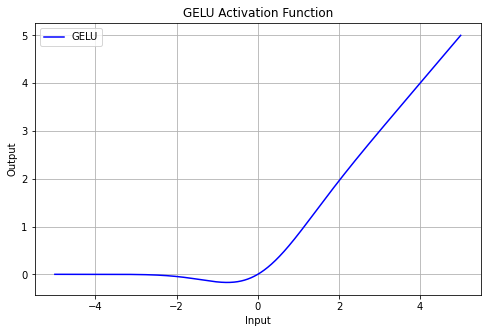

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# GELU 함수 정의 (TF 버전 그대로)
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * tf.pow(x, 3))))

# 입력 범위 설정
x = tf.linspace(-5.0, 5.0, 1000)
y = gelu(x)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='GELU', color='blue')
plt.title("GELU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.legend()
plt.show()


## 7.3 가중치, 편향치 초기화 함수

### 가중치  초기화 함수

딥러닝 모델에서 **가중치(weight)와 바이어스(bias)의 초기화**는  
학습의 안정성과 수렴 속도에 매우 중요한 영향을 미칩니다.  
BERT 모델에서는 다음과 같은 초기화 전략을 사용합니다.

`Truncated Normal(stddev=stddev)` 은 정규 분포에서 샘플링하되, 평균으로부터 +-2 표준편차 이상 벗어난 값은 버리고 다시 뽑는다.

극단적인 값들을 제거해 초기값이 너무 커지는것을 방지한다.

### 바이어스 초기화 함수

모든 바이어스를 0으로 초기화 한다.

딥러닝 아키텍처에서 바이어스는 기울기를 통해 학습 될 값이므로 처음에는 0으로 초기화 시켜줘야한다. 

In [105]:
def kernel_initializer(stddev=0.02):
    """
    가중치(weight) 초기화 함수 생성
    - TruncatedNormal: 정규분포에서 값 생성하되, ±2 표준편차 바깥 값은 버림
    - BERT 논문에서도 표준편차 0.02 사용
    Args:
        stddev: 생성할 랜덤값의 표준편차 (기본값 0.02)
    Returns:
        TruncatedNormal initializer 객체
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    바이어스(bias) 초기화 함수 생성
    - 모든 값을 0으로 초기화
    Returns:
        Zeros initializer 객체
    """
    return tf.zeros_initializer

## 7.4 Cofing는 Json 파일을 -> Python 처럼 쓸 수 있게 해주는 것

In [106]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


## 7.5 Token Embedding

BERT 모델에서 Token Embedding은 입력 토큰 ID를 고차원 벡터 공간으로 변환하는 과정입니다.  
이 과정을 통해 모델은 단순한 정수 ID가 아닌, **의미론적 정보**를 담고 있는 벡터로 입력을 처리할 수 있게 됩니다.


In [107]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    입력 임베딩과 출력 projection에 동일한 가중치를 사용하는 Shared Embedding Layer입니다.
    BERT 구조에서 embedding lookup과 output linear projection이 동일한 weight를 공유합니다.
    """

    def __init__(self, config, name="weight_shared_embedding"):
        """
        클래스 생성자
        Args:
            config: Config 객체 (모델 설정값 포함)
            name: 레이어 이름
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab     # 전체 vocabulary 크기
        self.d_model = config.d_model     # hidden dimension 크기 (임베딩 차원)

    def build(self, input_shape):
        """
        실제 공유 가중치(shared_weights)를 생성하는 함수.
        Keras Layer의 구조상, build()는 첫 호출 시 자동 실행됩니다.
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                name="weights",                               # 가중치 이름
                shape=[self.n_vocab, self.d_model],           # (vocab 크기, embedding 차원)
                initializer=kernel_initializer()              # truncated normal 초기화
            )

    def call(self, inputs, mode="embedding"):
        """
        레이어를 호출할 때 동작하는 메서드
        Args:
            inputs: 입력 텐서 (token ID 또는 hidden vector)
            mode: 실행 모드 - "embedding" 또는 "linear"
        Returns:
            임베딩 벡터 또는 linear projection 결과
        """
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")  # 잘못된 mode 입력 시 에러

    def _embedding(self, inputs):
        """
        임베딩 룩업 수행 (입력: token ID, 출력: embedding vector)
        Args:
            inputs: (batch_size, seq_len)의 token ID 텐서
        Returns:
            (batch_size, seq_len, d_model)의 임베딩 벡터
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):
        """
        hidden state를 vocabulary 차원으로 projection (출력단)
        Args:
            inputs: (batch_size, seq_len, d_model)
        Returns:
            (batch_size, seq_len, n_vocab)로 출력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]

        # 먼저 2D로 reshape 후 행렬 곱 수행
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (batch_size * seq_len, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # 원래 shape로 복원
        return outputs


## 7.6 Position Embedding

In [108]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Layer
    - 입력 시퀀스의 각 토큰 위치를 임베딩 벡터로 변환합니다.
    - 위치 정보를 학습 가능한 embedding table로 처리합니다.
    """

    def __init__(self, config, name="position_embedding"):
        """
        생성자 (initializer)
        Args:
            config: 설정 객체 (Config), n_seq와 d_model을 포함
            name: 레이어 이름
        """
        super().__init__(name=name)

        # 위치 임베딩을 위한 Embedding 레이어 생성
        # 입력: 위치 인덱스 (0 ~ n_seq-1), 출력: d_model 차원의 벡터
        self.embedding = tf.keras.layers.Embedding(
            input_dim=config.n_seq,        # 위치 수 (시퀀스 최대 길이)
            output_dim=config.d_model,     # 임베딩 차원
            embeddings_initializer=kernel_initializer()
        )

    def call(self, inputs):
        """
        레이어 호출 시 실행되는 메서드
        Args:
            inputs: 입력 텐서 (batch_size, n_seq)
                    → 값은 사용되지 않고 shape만 필요

        Returns:
            embed: 위치 임베딩 텐서 (batch_size, n_seq, d_model)
        """

        # 각 위치마다 인덱스를 생성: [0, 1, 2, ..., n_seq-1]
        # tf.ones_like → 입력 shape과 같은 텐서를 만들고, cumsum으로 인덱스 부여
        position = tf.cast(
            tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True),  # shape: (batch_size, n_seq)
            tf.int32
        )

        # 위치 인덱스에 대한 임베딩 벡터 조회
        embed = self.embedding(position)  # (batch_size, n_seq, d_model)

        return embed


## 7.7 ScaleDotProduct Attetion

In [109]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scaled Dot-Product Attention 레이어
    - Q, K, V를 입력으로 받아 어텐션 가중치를 계산하고 가중합을 반환합니다.
    """

    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        Args:
            name: 레이어 이름
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        어텐션 계산
        Args:
            Q: Query 벡터 (bs, n_head, seq_q, d_head)
            K: Key 벡터   (bs, n_head, seq_k, d_head)
            V: Value 벡터 (bs, n_head, seq_k, d_head)
            attn_mask: 마스킹 텐서 (bs, 1, seq_q, seq_k)
        Returns:
            attn_out: 어텐션 출력 (bs, n_head, seq_q, d_head)
        """

        # 1. 어텐션 스코어: Q × K^T (유사도)
        attn_score = tf.matmul(Q, K, transpose_b=True)  # (bs, n_head, seq_q, seq_k)

        # 2. 스케일링: d_head의 루트로 나눠서 softmax 안정화
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = attn_score / scale

        # 3. 마스킹 처리: 마스크가 1인 위치에는 매우 작은 음수를 더해 softmax 무시
        attn_scale -= 1.e9 * attn_mask  # 마스킹된 위치는 softmax 후 거의 0이 됨

        # 4. 확률로 변환: softmax
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)

        # 5. 가중합: attention output = softmax(QK^T) × V
        attn_out = tf.matmul(attn_prob, V)

        return attn_out


## 7.8 MultiHeadAttention

In [110]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi-Head Attention 레이어
    - 여러 개의 Attention Head를 병렬로 계산한 후 하나로 합치는 구조
    - 입력 Q, K, V에 대해 선형 변환 → 분할 → attention → 병합 → 최종 projection
    """

    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        Args:
            config: 설정값을 담은 Config 객체 (d_model, n_head, d_head 포함)
            name: 레이어 이름
        """
        super().__init__(name=name)

        self.d_model = config.d_model   # 전체 hidden size (예: 768)
        self.n_head = config.n_head     # 헤드 수 (예: 12)
        self.d_head = config.d_head     # 각 헤드당 차원 수 (예: 64) → d_model = n_head * d_head

        # Q, K, V 각각을 위한 Dense projection 레이어
        self.W_Q = tf.keras.layers.Dense(self.n_head * self.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(self.n_head * self.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(self.n_head * self.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

        # Scaled Dot-Product Attention 연산을 담당하는 서브 레이어
        self.attention = ScaleDotProductAttention(name="self_attention")

        # 여러 헤드의 attention 출력을 합쳐서 최종 output으로 변환
        self.W_O = tf.keras.layers.Dense(self.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        레이어 실행
        Args:
            Q, K, V: (batch, seq_len, d_model) 입력
            attn_mask: (batch, seq_len, seq_len) 어텐션 마스크
        Returns:
            attn_out: (batch, seq_len, d_model) 최종 attention 결과
        """
        batch_size = tf.shape(Q)[0]

        # 1. Q, K, V를 n_head 개로 분리 (multi-head 준비)
        # W_Q/K/V → shape: (batch, seq_len, n_head * d_head)
        # reshape + transpose → (batch, n_head, seq_len, d_head)
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])

        # 2. 마스크에도 헤드 차원을 맞춰주기 위해 차원 추가
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)  # shape: (batch, 1, seq_q, seq_k)

        # 3. Scaled Dot-Product Attention 실행 (각 head 별로 병렬 처리)
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (batch, n_head, seq_len, d_head)

        # 4. (n_head, d_head)를 다시 합쳐 원래 차원으로 복원
        attn_out = tf.transpose(attn_out, [0, 2, 1, 3])                      # → (batch, seq_len, n_head, d_head)
        attn_out = tf.reshape(attn_out, [batch_size, -1, self.d_model])     # → (batch, seq_len, d_model)

        # 5. 최종 projection (출력 차원으로 다시 맵핑)
        attn_out = self.W_O(attn_out)  # (batch, seq_len, d_model)

        return attn_out


## 7.9 PositionWiseFeedForward

In [111]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position-wise Feed Forward Network (FFN)
    - Transformer 각 토큰 위치마다 동일한 FFN을 독립적으로 적용
    - 두 개의 Dense 레이어 (d_model → d_ff → d_model)
    """

    def __init__(self, config, name="feed_forward"):
        """
        생성자
        Args:
            config: Config 객체 (d_model, d_ff 포함)
            name: 레이어 이름
        """
        super().__init__(name=name)

        # 첫 번째 Dense: 확장 → d_ff
        self.W_1 = tf.keras.layers.Dense(
            config.d_ff,                    # 중간 차원 확장 (예: 3072)
            activation=gelu,                # BERT에서는 GELU 사용
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer()
        )

        # 두 번째 Dense: 축소 → d_model
        self.W_2 = tf.keras.layers.Dense(
            config.d_model,                 # 입력 차원으로 복원 (예: 768)
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer()
        )

    def call(self, inputs):
        """
        레이어 호출 시 실행
        Args:
            inputs: (batch_size, seq_len, d_model)
        Returns:
            ff_val: (batch_size, seq_len, d_model)
        """
        ff_val = self.W_2(self.W_1(inputs))  # GELU → Linear
        return ff_val


## 7.10 EncoderLayer

In [112]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Transformer Encoder Layer
    - 하나의 블록은 Self-Attention → Add & Norm → FFN → Add & Norm 순서로 구성됩니다.
    """

    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        Args:
            config: 모델 설정 객체
            name: 레이어 이름
        """
        super().__init__(name=name)

        # 1. Self-Attention 블록
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        # 2. Position-wise FFN 블록
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        # 3. Dropout (공통으로 사용)
        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        Encoder Layer 실행 함수
        Args:
            enc_embed: (batch_size, seq_len, d_model) → 입력 임베딩 or 이전 레이어 출력
            self_mask: (batch_size, seq_len, seq_len) → padding 마스크
        Returns:
            enc_out: EncoderLayer의 출력 (batch_size, seq_len, d_model)
        """

        # 1. Multi-Head Self-Attention + Residual + LayerNorm
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)  # Self-Attention
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))  # Add & Norm

        # 2. Position-wise FFN + Residual + LayerNorm
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))  # Add & Norm

        return enc_out


## 7.11 BERT Layer

In [113]:
class BERT(tf.keras.layers.Layer):
    """
    BERT 모델 전체 구조
    - 입력: (enc_tokens, segments)
    - 출력: [CLS] 토큰 벡터 (문장 분류용), MLM 예측 logits
    """

    def __init__(self, config, name="bert"):
        """
        생성자
        Args:
            config: 설정 정보 객체 (Config)
            name: 레이어 이름
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad  # pad 토큰 ID

        # 1. 임베딩 관련 레이어들
        self.embedding = SharedEmbedding(config)                        # token embedding (가중치 공유)
        self.position = PositionEmbedding(config)                       # position embedding
        self.segment = tf.keras.layers.Embedding(2, config.d_model,     # segment A/B 구분 (0/1)
                                                 embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        # 2. 인코더 레이어 N개
        self.encoder_layers = [
            EncoderLayer(config, name=f"encoder_layer_{i}")
            for i in range(config.n_layer)
        ]

        # 3. dropout
        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        BERT 실행 함수
        Args:
            inputs: 튜플 (enc_tokens, segments)
            - enc_tokens: (batch, seq_len)
            - segments: (batch, seq_len)
        Returns:
            logits_cls: [CLS] 토큰 벡터 (batch, d_model)
            logits_lm: 전체 토큰에 대한 vocab logits (batch, seq_len, vocab_size)
        """
        enc_tokens, segments = inputs

        # 1. Padding 위치를 가리는 mask 생성
        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        # 2. 임베딩 lookup (token + position + segment)
        enc_embed = self.get_embedding(enc_tokens, segments)  # (batch, seq_len, d_model)
        enc_out = self.dropout(enc_embed)

        # 3. 인코더 레이어 반복 적용
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        # 4. 출력
        logits_cls = enc_out[:, 0]                          # 문장 분류용 [CLS] 토큰 출력
        logits_lm = self.embedding(enc_out, mode="linear")  # MLM 예측용: linear projection

        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        전체 embedding 계산 함수
        Args:
            tokens: token id 입력 (batch, seq_len)
            segments: segment id 입력 (batch, seq_len)
        Returns:
            embed: 최종 임베딩 벡터 (batch, seq_len, d_model)
        """
        embed = (
            self.embedding(tokens) +           # token embedding
            self.position(tokens) +            # position embedding
            self.segment(segments)             # segment embedding
        )
        embed = self.norm(embed)               # layer normalization
        return embed


In [114]:
class PooledOutput(tf.keras.layers.Layer):
    """
    BERT의 [CLS] 벡터를 활용한 NSP 분류기
    - Dense + tanh → Dense + softmax 구조
    NSP용 출력 레이어
    """

    def __init__(self, config, n_output, name="pooled_output"):
        """
        Args:
            config: 모델 설정값
            n_output: 출력 클래스 수 (NSP는 2개: is_next / not_next)
        """
        super().__init__(name=name)

        # 1. [CLS] 벡터를 비선형 변환
        self.dense1 = tf.keras.layers.Dense(
            config.d_model, activation=tf.nn.tanh,
            kernel_initializer=kernel_initializer(),
            bias_initializer=bias_initializer()
        )

        # 2. softmax로 NSP 결과 출력
        self.dense2 = tf.keras.layers.Dense(
            n_output, use_bias=False, activation=tf.nn.softmax,  # 이미 마지막에 softmax 있음
            name="nsp", kernel_initializer=kernel_initializer()
        )

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs


In [115]:
def build_model_pre_train(config):
    """
    BERT 사전학습 모델 구성 함수
    - 입력: enc_tokens, segments
    - 출력: NSP softmax 결과, MLM softmax 결과
    """
    # 1. 입력 정의
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")  # (batch, seq_len)
    segments = tf.keras.layers.Input((None,), name="segments")      # (batch, seq_len)

    # 2. BERT 인코더 호출
    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))  # (batch, d_model), (batch, seq_len, vocab)

    # 3. NSP 출력 레이어
    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)  # (batch, 2)

    # 4. MLM 출력 레이어
    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)   # (batch, seq_len, vocab)

    # 5. 모델 정의
    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model


In [116]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.05,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [117]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 2s 15ms/step - loss: 11.1566 - nsp_loss: 0.7409 - mlm_loss: 10.4158 - nsp_acc: 0.4000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 14ms/step - loss: 9.9240 - nsp_loss: 0.6217 - mlm_loss: 9.3023 - nsp_acc: 0.8000 - mlm_acc: 0.0200


# Pretrain

In [118]:
def lm_loss(y_true, y_pred):
    """
    MLM 손실 함수 (Masked Language Modeling용)
    - padding 위치(0)를 무시하고, 실제 마스크된 위치만 학습
    - MLM 학습 중요도를 높이기 위해 20배 보정
    Args:
        y_true: 정답 토큰 ID (batch, seq_len)
        y_pred: 예측 로짓 (batch, seq_len, vocab_size)
    Returns:
        손실 값 (batch, seq_len)
    """
    # 1. 기본 sparse categorical cross entropy 계산 (mask 미적용)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction=tf.keras.losses.Reduction.NONE  # 위치별로 loss 유지
    )(y_true, y_pred)

    # 2. PAD 토큰(0) 위치를 마스크로 제거
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)  # (bs, seq_len)
    loss *= mask  # PAD 위치의 손실은 0으로 만듦

    # 3. MLM은 더 어려운 task이므로 loss를 20배 증폭
    return loss * 20


In [119]:
def lm_acc(y_true, y_pred):
    """
    MLM 정확도 계산 함수
    - PAD 위치는 정확도에서 제외
    Args:
        y_true: 정답 토큰 ID (batch, seq_len)
        y_pred: 예측 로짓 (batch, seq_len, vocab_size)
    Returns:
        정확도 스칼라 값
    """
    # 1. 예측 확률 → 클래스 ID
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)  # (bs, seq_len)

    # 2. 정답 여부 판단
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)

    # 3. PAD 위치 제거
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask  # PAD 위치의 예측은 정확도에서 제외

    # 4. 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)  # 분모가 0이 되지 않도록 보호
    return accuracy


In [120]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Warmup + Cosine Decay Learning Rate Schedule
    - 초반엔 선형 증가 (Warmup)
    - 이후에는 Cosine 함수 기반으로 감소
    """

    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        Args:
            train_steps: 전체 학습 step 수
            warmup_steps: warmup 동안 선형 증가할 step 수
            max_lr: warmup 이후에 도달할 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps, "Warmup step은 전체보다 작아야 합니다."
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        현재 step에 따른 learning rate 계산
        Args:
            step_num: 현재 step (정수)
        Returns:
            학습률 (scalar tensor)
        """
        # 1. Warmup 단계 여부 판단
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)

        # 2. warmup 단계: 0 → 1까지 선형 증가
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps

        # 3. cosine 단계: pi를 기준으로 학습률 점점 감소
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / \
                   max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))

        # 4. warmup이면 lr1 사용, 아니면 lr2 사용
        return (state * lr1 + (1.0 - state) * lr2) * self.max_lr


0~500 step: 학습률이 선형 증가 → warm-up

500~4000 step: 완만한 곡선 형태로 감소 → cosine decay

전체 곡선: 부드럽게 올라갔다가 천천히 떨어지는 종 모양(Bump + Tail)

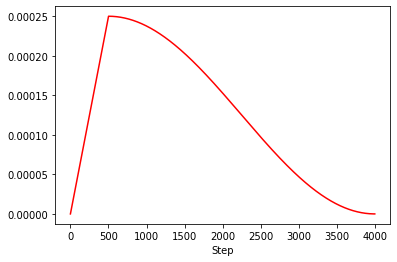

In [121]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [122]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 10629632    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [125]:
# 1. 모델 가중치 저장 콜백 설정
save_weights = tf.keras.callbacks.ModelCheckpoint(
    f"{model_dir}/bert_pre_train.hdf5",   # 저장 경로
    monitor="mlm_lm_acc",                 # MLM 정확도를 기준으로 가장 좋은 모델 저장
    verbose=1,                            # 저장 시 로그 출력
    save_best_only=True,                 # 가장 성능 좋은 모델만 저장
    mode="max",                           # 정확도이므로 큰 값이 더 좋은 것
    save_freq="epoch",                    # 매 epoch마다 체크
    save_weights_only=True                # 전체 모델이 아닌 가중치만 저장
)
# 2. 모델 학습 및 학습 이력 저장
history = pre_train_model.fit(
    x=pre_train_inputs,                         # 입력: (enc_tokens, segments)
    y={
        "nsp": pre_train_labels[0],             # NSP 라벨 (is_next 여부)
        "mlm": pre_train_labels[1]              # MLM 라벨 (마스크된 단어 정답)
    },
    batch_size=batch_size,                      # 배치 크기
    epochs=epochs,                              # 에폭 수
    callbacks=[save_weights],                   # 가중치 저장 콜백
    verbose=1                                   # 학습 로그 출력
)

Epoch 1/10
 861/2000 [===========>..................] - ETA: 5:28 - loss: 9.0138 - nsp_loss: 0.4075 - mlm_loss: 8.6063 - nsp_acc: 0.9052 - mlm_lm_acc: 0.2506

KeyboardInterrupt: 

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(history.history['mlm_loss'], 'r-- ', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 4, 4)
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

##  학습 로그 요약 및 분석

**첫번째 실험 (순정)**

| Epoch | NSP Loss | MLM Loss | NSP Accuracy | MLM LM Accuracy | 성능 개선 여부 |
|-------|----------|----------|--------------|------------------|----------------|
| 1     | 0.6004   | 19.5624  | 0.6708       | 0.1337           | ✅ 초기화 |
| 2     | 0.5926   | 18.8241  | 0.6839       | 0.1400           | ✅ |
| 3     | 0.5668   | 17.2935  | 0.7222       | 0.1600           | ✅ |
| 4     | 0.5368   | 15.6243  | 0.7602       | 0.1873           | ✅ |
| 5     | 0.5073   | 14.7069  | 0.7959       | 0.2065           | ✅ |
| 6     | 0.4824   | 14.0687  | 0.8238       | 0.2203           | ✅ |
| 7     | 0.4610   | 13.6189  | 0.8475       | 0.2308           | ✅ |
| 8     | 0.4463   | 13.3042  | 0.8638       | 0.2386           | ✅ |
| 9     | 0.4364   | 13.1060  | 0.8742       | 0.2436           | ✅ |
| 10    | `0.4309`   | `13.0093`  | `0.8802`       | `0.2458`           | ✅ |

**두번째 실험 [ Mask_prob(0.15→0.1),  droput 0.1 → 0.05) ]**

mlm Loss 는 8까지 떨어지는 모습을 보였으나 Accuracy는 큰차이점이 없었음

---

###  NSP Task

- 정확도: **67% → 88%**로 상승  
- Loss 지속 감소 → 빠르게 수렴됨  
- 📌 *NSP는 비교적 쉬운 task로 빠르게 학습되는 것이 일반적입니다.*

---

###  MLM Task

- Accuracy: **13.3% → 24.6%**까지 상승  
- Loss도 꾸준히 감소 중 → **학습이 정상적으로 진행 중**  
- 📌 *MLM은 예측해야 할 단어가 많고 난이도가 높아 느리게 학습됨*

---

###  결론

- **전체 학습 흐름**: 매우 안정적으로 진행됨  
- **NSP**: 빠르게 수렴 (거의 완료)  
- **MLM**: 느리지만 계속 성능 향상 중  
- **추가 학습 여지 있음**: MLM 정확도는 더 학습하면 향상 가능성 있음

> 🔍 따라서, 현재 모델은 사전학습이 성공적으로 진행되었으며  
> 추가적인 epoch 학습을 통해 MLM 성능을 더 끌어올릴 수 있습니다.
